In [57]:
import importlib
import numpy as np
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [58]:
import env.make
import env.eval
import utils.utils as utils
importlib.reload(env.make)
importlib.reload(env.eval)
importlib.reload(utils);

In [59]:
%config InlineBackend.figure_format='retina'

In [60]:
device = utils.find_device(force_cpu=True)

Using device cpu


In [61]:
fig_folder, backup_folder = utils.make_folders()

Figures folder: ./figures
Backup folder: ./backup


# Fix horizon

In [62]:
ENV = env.make.mujoco_cartpole()
TIME_HORIZON = 20

# Using random policy

In [63]:
n_sample = 1000
x = torch.rand((n_sample, TIME_HORIZON))
env.eval.trajectories(trajectories=x, env=ENV, verbose=True);

Avg reward: 0.306 +/- 0.176; Range = 0.150, 1.000


# Using unit gaussian

In [64]:
n_sample = 1000
x = torch.sigmoid(torch.randn((n_sample, TIME_HORIZON)))
env.eval.trajectories(x, env=ENV, verbose=True);

Avg reward: 0.354 +/- 0.185; Range = 0.150, 1.000


# Using reinforce

In [70]:
epochs = 1000 

mu = torch.nn.Parameter(torch.randn(TIME_HORIZON))
logvar = torch.nn.Parameter(torch.randn(TIME_HORIZON))
optimizer = torch.optim.Adam([mu, logvar], lr=0.01)

n_sample = 20

kl_div_factor = 0.01
p = torch.distributions.Normal(torch.zeros(TIME_HORIZON), torch.ones(TIME_HORIZON))
# p = dist.ContinuousBernoulli(probs=torch.ones(n_steps)*0.5)
# p = None

hist_loss = []

with tqdm(total=epochs) as pbar:
    for epoch in range(epochs):
        
        optimizer.zero_grad()

        q = torch.distributions.Normal(mu, torch.exp(0.5*logvar))
        trajectories = torch.sigmoid(q.sample((n_sample, )))
        np_trajectories = trajectories.cpu().numpy()
        
        loss, total_weight = 0, 0
    
        for traj, np_traj in zip(trajectories, np_trajectories):
    
            reward = env.eval.trajectory(trajectory=np_traj, env=ENV)
            logp_traj = q.log_prob(traj).sum()
            loss -= logp_traj.exp() * reward
            total_weight += logp_traj.exp()

        loss /= total_weight
        
        if p is not None:
            kl_div = torch.distributions.kl_divergence(q, p).sum()
            loss += kl_div_factor * kl_div

        loss.backward()
        optimizer.step()

        pbar.update()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        hist_loss.append(loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

In [71]:
with torch.no_grad():
    env.eval.trajectories(
        torch.sigmoid(torch.distributions.Normal(mu, torch.exp(0.5*logvar)).sample((1000, ))), 
        env=ENV,
        verbose=True);

Avg reward: 0.367 +/- 0.192; Range = 0.150, 1.000


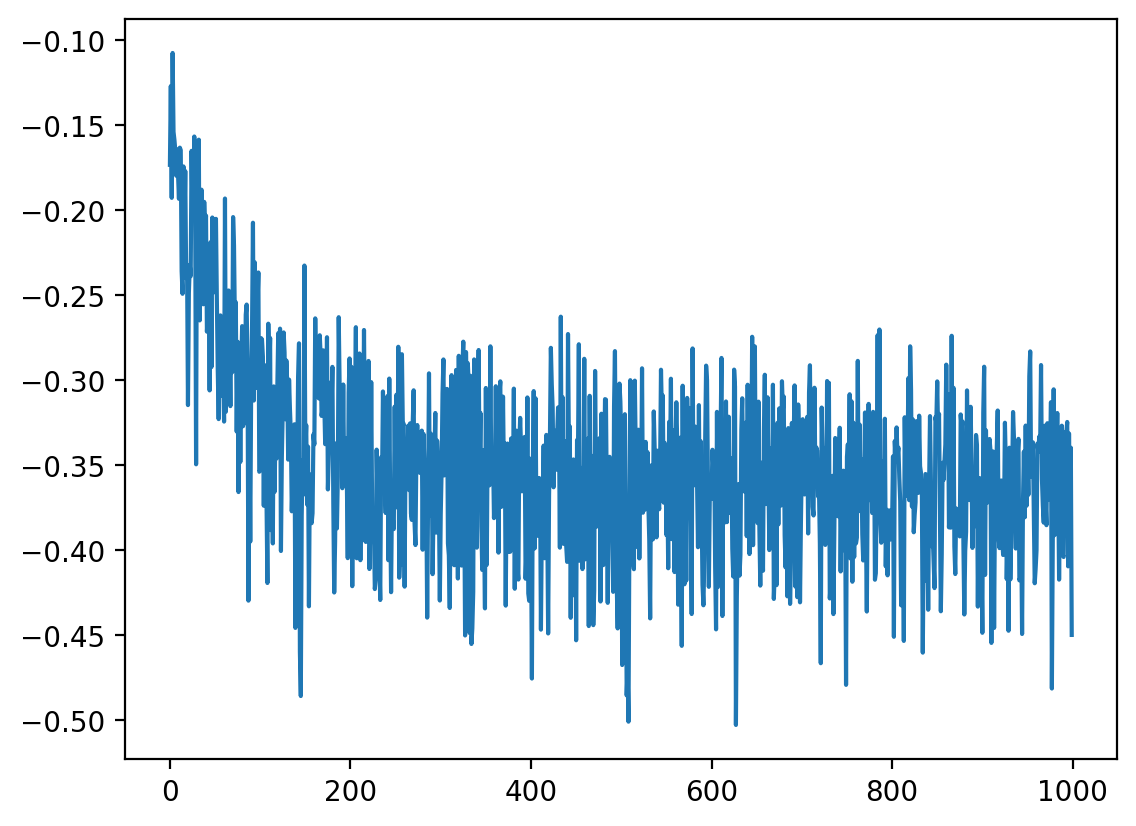

In [72]:
fig, ax = plt.subplots()
ax.plot(hist_loss);